In [6]:
import torch
import matplotlib.pyplot as plt
from OUR_utils.utils import *
from Models.model import ConTextTransformer

In [7]:
config = dict(
     epochs=70,
     classes=28,
     batch_size=128,
     learning_rate=0.001,
     input_size=256,
     dim = 256,
     depth = 2,
     heads = 4,
     mlp_dim = 512,
     dataset="Con-Text dataset",
     architecture="ConTextTransformer")
device = 'cuda'

In [11]:
Model = ConTextTransformer(num_classes = config["classes"], dim = 256, depth = 2, heads = 4, mlp_dim = 512)
Model.load_state_dict(torch.load('/home/xnmaster/dlnn-project_ia-group_1/CheckPoints/model_state_dict_ADAM.pth'))
Model = Model.to(device)

/anaconda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
directory_test_train_files = '/home/xnmaster/data/'            
images_directory           = '/home/xnmaster/data/JPEGImages/'
fasttext_obj = fasttext.load_model('/home/xnmaster/cc.en.300.bin')
input_size   = 256
batch_size   = 128

test  = ConTextDataset(directory_test_train_files, images_directory, fasttext_obj, train = False, transform = get_transform(input_size, train = False))
test_loader   = make_loader(test,  batch_size=batch_size)

In [18]:
business_dict = {
    0: "Bakery",
    1: "Barber",
    2: "Bistro",
    3: "Bookstore",
    4: "Cafe",
    5: "ComputerStore",
    6: "CountryStore",
    7: "Diner",
    8: "DiscountHouse",
    9: "Dry Cleaner",
    10: "Funeral",
    11: "Hotspot",
    12: "MassageCenter",
    13: "MedicalCenter",
    14: "PackingStore",
    15: "PawnShop",
    16: "PetShop",
    17: "Pharmacy",
    18: "Pizzeria",
    19: "RepairShop",
    20: "Restaurant",
    21: "School",
    22: "SteakHouse",
    23: "Tavern",
    24: "TeaHouse",
    25: "Theatre",
    26: "Tobacco",
    27: "Motel"
}

Correctly predicted: 54.6875%


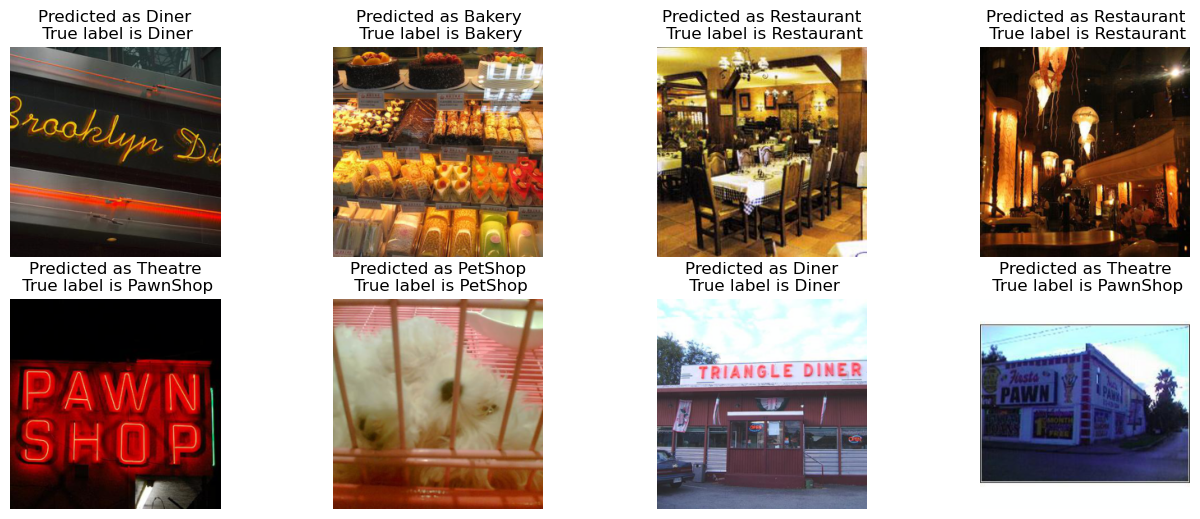

In [31]:
with torch.no_grad():

    img, text, target = next(iter(test_loader))
    img, text, target = img.to(device), text.to(device), target.to(device)

    output = Model(img, text)
    predictions = np.argmax(output.cpu().numpy(), axis=1).tolist()
    true = target.cpu().numpy().tolist()
      
    plt.figure(figsize=(16, 6))
    
    print("Correctly predicted: {}%".format(100*sum(p == t for p, t in zip(predictions, true))/len(predictions)) )

    for i in range(8):
        plt.subplot(2, 4, i + 1)
        
        image = img[i,...].cpu().clone().detach() # Create a copy of the tensor in the CPU
        image = image.permute(1, 2, 0) # The original tensor is formatted as Channels, Height, Width - move channels to the end
        image = image.numpy()

        # Undo the normalisation we applied before
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image = image.clip(0, 1)

        plt.imshow(image)
        
        plt.axis('off')
        plt.title('Predicted as {}\n True label is {}'.format(business_dict[predictions[i]], business_dict[true[i]], ))